In [ ]:
# Importing libraries and modules
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
# Load data
from google.colab import drive
drive.mount('/content/gdrive')
col_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('/content/gdrive/MyDrive/training.csv',encoding='latin-1' ,names = col_names, header = None)

Mounted at /content/gdrive


In [ ]:
df = df.drop(['ids', 'date', 'flag', 'user'], axis = 1)
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [ ]:
def text_cleaning(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)     # removing @mentions
  text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)  # removing @mentions 
  text = re.sub(r'@[A-Za-z]+', '', text)        # removing @mentions
  text = re.sub(r'@[-)]+', '', text)            # removing @mentions
  text = re.sub(r'#', '', text )                # removing '#' sign
  text = re.sub(r'RT[\s]+', '', text)           # removing RT
  text = re.sub(r'https?\/\/\S+', '', text)     # removing the hyper link
  text = re.sub(r'&[a-z;]+', '', text)          # removing '&gt;'

  return text

In [ ]:
# applying the text cleaning function on tweets
df['text'] = df['text'].apply(text_cleaning)
df.head(10)

,target,text
0,0,"http://twitpic.com/2y1zl - Awww, that's a bum..."
1,0,is upset that he can't update his Facebook by ...
2,0,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am..."
5,0,not the whole crew
6,0,Need a hug
7,0,"hey long time no see! Yes.. Rains a bit ,onl..."
8,0,_K nope they didn't have it
9,0,que me muera ?


In [ ]:
# splitting the data into training and testing data

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['text'].values, df['target'].values, test_size=0.10)

In [ ]:
# checking the data split
print('text: ', x_train[0])
print('sentiment: ', y_train[0])

text:   That's news to me. Hadn't heard, but at the same time, haven't been lookin. 
sentiment:  4


In [ ]:
# converting the strings into integers using Tokenizer 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

# instantiating the tokenizer
max_vocab = 20000000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(x_train)

In [ ]:
# checking the word index and find out the vocabulary of the dataset
wordidx = tokenizer.word_index
V = len(wordidx)
print('The size of datatset vocab is: ', V)

The size of datatset vocab is:  358652


In [ ]:
# converting tran and test sentences into sequences
train_seq = tokenizer.texts_to_sequences(x_train)
test_seq = tokenizer.texts_to_sequences(x_test)
print('Training sequence: ', train_seq[0])
print('Testing sequence: ', test_seq[0])

Training sequence:  [142, 457, 2, 14, 2416, 515, 18, 23, 3, 256, 49, 337, 97, 1857]
Testing sequence:  [982, 147, 17, 543, 7, 13, 2325, 5281, 7, 4, 683, 851, 94, 57240, 637, 2, 14, 105, 357, 6, 1, 376, 4, 683, 851]


In [ ]:
# padding the sequences to get equal length sequence because its conventional to use same size sequences
# padding the traing sequence
pad_train = pad_sequences(train_seq)
T = pad_train.shape[1]
print('The length of training sequence is: ', T)

The length of training sequence is:  118


In [ ]:
# padding the test sequence
pad_test = pad_sequences(test_seq, maxlen=T)
print('The length of testing sequence is: ', pad_test.shape[1])

The length of testing sequence is:  118


In [ ]:
# building the model

from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model

D = 20 
M = 15

i = Input (shape=(T, ))   
x = Embedding(V+1, D)(i)    # V+1 because the indexing of the words in vocab (V) start from 1 not 0
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)


In [ ]:
# compiling the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# training the model
r = model.fit(pad_train, y_train, validation_data=(pad_test, y_test), epochs=2)

Epoch 1/2
45000/45000 [==============================] - 4533s 101ms/step - loss: -174635.2969 - accuracy: 0.0381 - val_loss: -512570.1562 - val_accuracy: 0.0718
Epoch 2/2
45000/45000 [==============================] - 4499s 100ms/step - loss: -1174242.2500 - accuracy: 0.0669 - val_loss: -1997211.2500 - val_accuracy: 0.0702


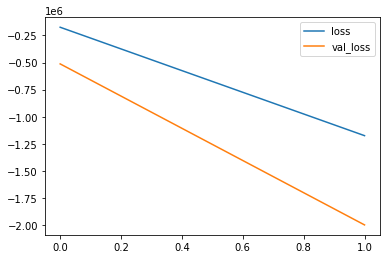

In [ ]:
# Evaluating the model
# plotting the loss and validation loss of the model
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

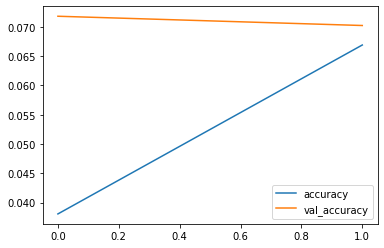

In [ ]:
# plotting the accuracy and validation accuracy of the model
plt.plot(r.history['accuracy'], label= 'accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
# Predicting the sentiment of any text

def predict_sentiment(text):
  # preprocessing the given text 
  text_seq = tokenizer.texts_to_sequences(text)
  text_pad = pad_sequences(text_seq, maxlen=T)

  # predicting the class
  predicted_sentiment = model.predict(text_pad).round()

  if predicted_sentiment == 1.0:
    return(print('It is a positive sentiment'))
  else:
    return(print('It is a negative sentiment'))
